<a href="https://colab.research.google.com/github/ben-oxley/colab-opencl-experiments/blob/main/particle-sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pyopencl
!pip install pillow
from __future__ import division
import numpy as np
import pyopencl as cl
import pyopencl.array
from pyopencl.clrandom import rand as clrand
import pyopencl.cltypes as cltypes
from PIL import Image
from IPython.display import display

     |████████████████████████████████| 878 kB 12.1 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=860c51d941c943071de8923f863bb5f4d8d658d79c61375933e838c5149ed9e5
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pytools


In [3]:
%load_ext pyopencl.ipython_ext

In [4]:
print(pyopencl.get_platforms())
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)

[<pyopencl.Platform 'NVIDIA CUDA' at 0x561c8b75c9e0>]


In [5]:
%%cl_kernel

__kernel void sum_vector(__global const float4 *a,
__global const float4 *b, __global float4 *c)
{
  int gid = get_global_id(0);
  c[gid].x = fmod((a[gid].x + b[gid].x * 0.001),1000.0);
  c[gid].y = fmod((a[gid].y + b[gid].y * 0.001),1000.0);
}

__kernel void to_canvas(__global const float4 *a, __global float *canvas)
{
  int gid = get_global_id(0);
  int x = convert_int(a[gid].x);
  int y = convert_int(a[gid].y)*1000;
  canvas[x+y] +=1;
}

In [6]:
n = 10_000_000

a = cl.array.zeros(queue, n, dtype=cltypes.float4)
a = clrand(queue, (n,), dtype=cltypes.float4, a=0.0, b=1000.0)


b_host = np.random.randn(n).astype(cltypes.float4)
b = cl.array.to_device(queue, b_host)
c = cl.array.zeros(queue, n, dtype=cltypes.float4)

In [7]:
sum_vector(queue, (n,), None, a.data, b.data, c.data)

In [8]:
print(c.get())

[(942.95374, 956.1075 , 0., 0.) (748.3258 , 133.92337, 0., 0.)
 (122.078  , 788.4591 , 0., 0.) ... (651.6364 , 750.4278 , 0., 0.)
 (811.0945 , 290.30624, 0., 0.) (363.16046, 291.41885, 0., 0.)]


In [9]:
canvas = cl.array.zeros(queue, 1000*1000, dtype=cltypes.float)
to_canvas(queue,(n,),None,c.data,canvas.data)

[[15.  8. 11. ... 11. 10.  8.]
 [10. 10. 11. ... 12. 11. 14.]
 [ 9.  8.  4. ... 12.  5. 17.]
 ...
 [12. 12. 10. ...  9.  3. 17.]
 [ 7. 10.  4. ... 10.  7.  8.]
 [17. 15.  6. ... 10.  9.  8.]]


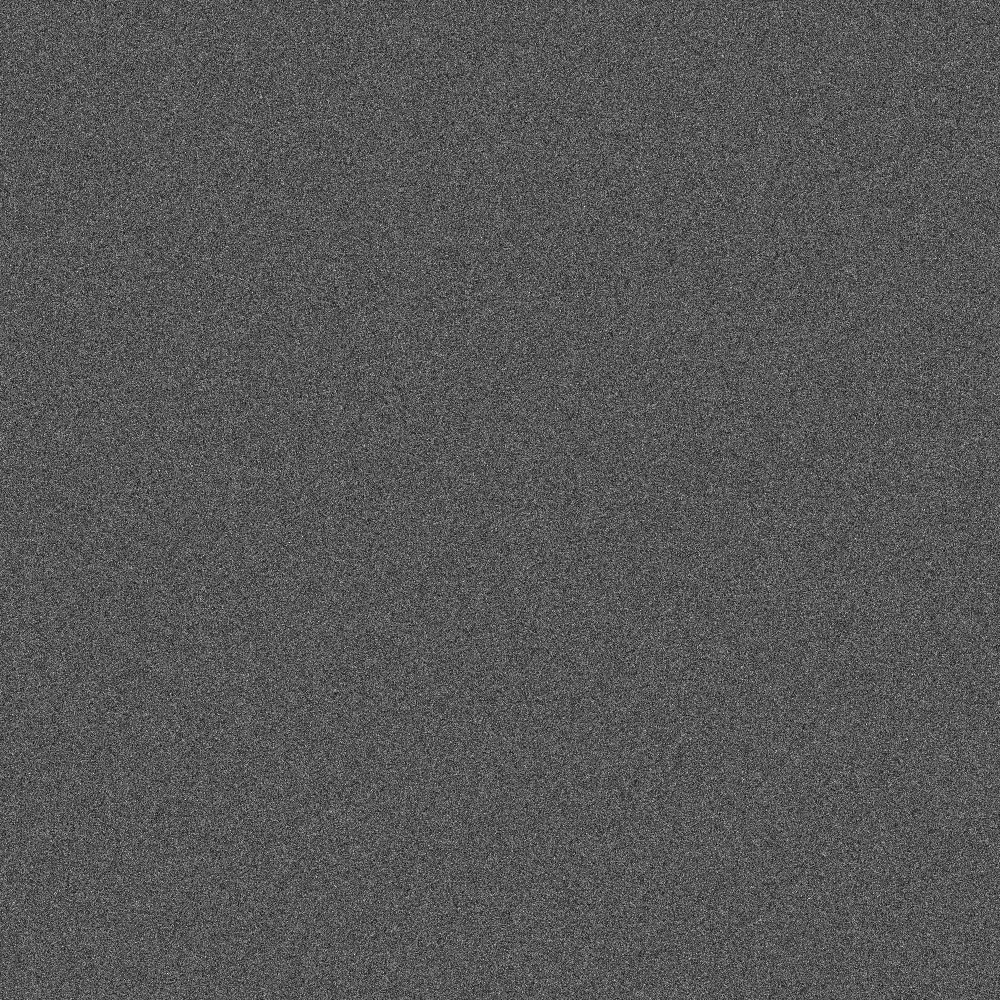

In [10]:
canvas_return = np.array(canvas.get())
canvas_return = np.reshape(canvas_return,(1000,1000))
print(canvas_return)
max = canvas_return.max()
img = Image.fromarray(np.uint8(canvas_return/max * (255)) , 'L')
img.show()
display(img)